param_num: 448802
[0, 2.5671045939127604, 5.134209187825521, 7.701313781738281, 10.268418375651041, 12.835522969563801, 15.40262756347656, 17.96973215738932, 20.53683675130208, 23.10394134521484, 25.6710459391276, 28.238150533040358, 30.805255126953117, 33.37235972086588, 35.93946431477864, 38.5065689086914, 41.07367350260416, 43.64077809651692, 46.20788269042968, 48.77498728434244, 51.3420918782552, 53.909196472167956, 56.476301066080715, 59.043405659993475, 61.610510253906234, 64.177614847819, 66.74471944173176, 69.31182403564452, 71.87892862955728, 74.44603322347004, 77.0131378173828, 79.58024241129556, 82.14734700520832, 84.71445159912108, 87.28155619303384, 89.8486607869466, 92.41576538085936, 94.98286997477211, 97.54997456868487, 100.11707916259763, 102.6841837565104, 105.25128835042315, 107.81839294433591, 110.38549753824867, 112.95260213216143, 115.51970672607419, 118.08681131998695, 120.65391591389971, 123.22102050781247, 125.78812510172523, 128.355229695638, 130.9223342895507

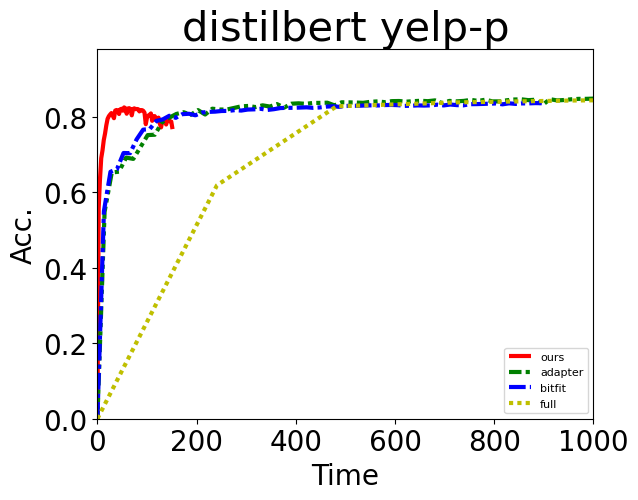

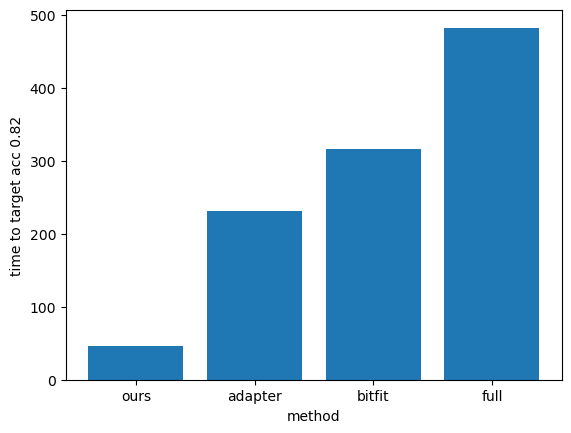

In [2]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "yelp-p"
model = "distilbert"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/distilbert_yelp-p/fedFwd_distilbert_yelp-p_lr0.01_client_num_1000_numerical.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yelp-p/fedsgd_distilbert_yelp-p_lr0.01_client_num_10_adapter.log",
    "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yelp-p/fedsgd_distilbert_yelp-p_lr0.01_client_num_10_bitfit.log",
    "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yelp-p/fedsgd_distilbert_yelp-p_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":1,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18,"yelp-p":65}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.82
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()

param_num: 448802
[0, 10.150437927246093, 20.300875854492187, 30.45131378173828, 40.601751708984374, 50.75218963623047, 60.902627563476564, 71.05306549072266, 81.20350341796875, 91.35394134521484, 101.50437927246092, 111.65481719970701, 121.8052551269531, 131.9556930541992, 142.1061309814453, 152.25656890869138, 162.40700683593747, 172.55744476318355, 182.70788269042964, 192.85832061767573, 203.00875854492182, 213.1591964721679, 223.309634399414, 233.46007232666008, 243.61051025390617, 253.76094818115226, 263.91138610839835, 274.06182403564446, 284.2122619628906, 294.3626998901367, 304.5131378173828, 314.66357574462893, 324.81401367187505, 334.96445159912116, 345.1148895263673, 355.2653274536134, 365.4157653808595, 375.5662033081056, 385.71664123535174, 395.86707916259786, 406.017517089844, 416.1679550170901, 426.3183929443362, 436.4688308715823, 446.61926879882844, 456.76970672607456, 466.9201446533207, 477.0705825805668, 487.2210205078129, 497.371458435059, 507.52189636230514, 517.67

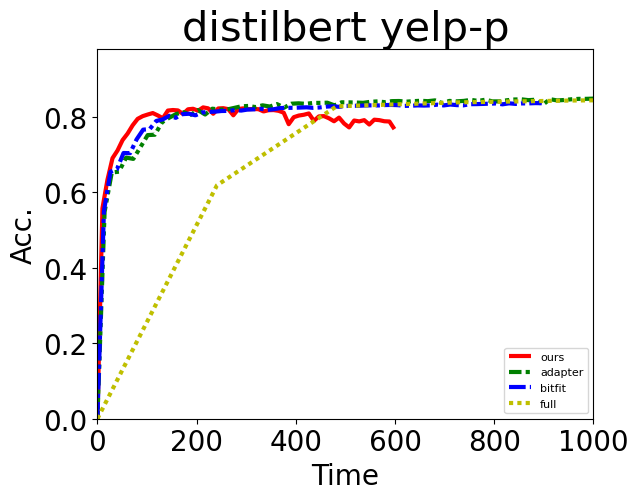

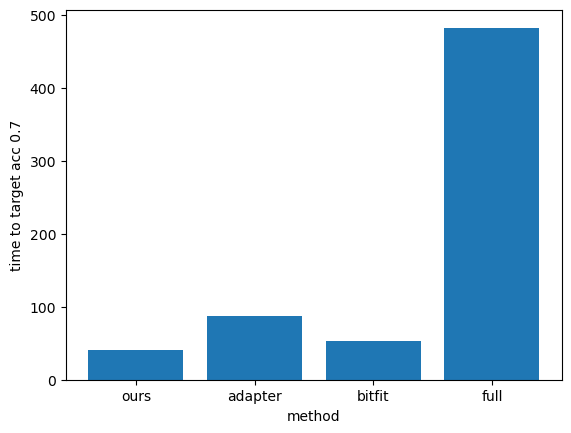

In [3]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "yelp-p"
model = "distilbert"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/distilbert_yelp-p/fedFwd_distilbert_yelp-p_lr0.01_client_num_1000_numerical.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yelp-p/fedsgd_distilbert_yelp-p_lr0.01_client_num_10_adapter.log",
    "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yelp-p/fedsgd_distilbert_yelp-p_lr0.01_client_num_10_bitfit.log",
    "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yelp-p/fedsgd_distilbert_yelp-p_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":8,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18,"yelp-p":65}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.7
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()